# Stochastic Gradient Boosting
Gradient boosting is a greedy procedure.

New decision trees are added to the model to correct the residual error of the existing model.

Each decision tree is created using a greedy search procedure to select split points that best minimize an objective function. This can result in trees that use the same attributes and even the same split points again and again.

Bagging is a technique where a collection of decision trees are created, each from a different random subset of rows from the training data. The effect is that better performance is achieved from the ensemble of trees because the randomness in the sample allows slightly different trees to be created, adding variance to the ensembled predictions.

Random forest takes this one step further, by allowing the features (columns) to be subsampled when choosing split points, adding further variance to the ensemble of trees.

These same techniques can be used in the construction of decision trees in gradient boosting in a variation called stochastic gradient boosting.

It is common to use aggressive sub-samples of the training data such as 40% to 80%.

###### All credit for this tutorial goes to Jason Brownlee, PhD. I have merely followed his tutorial for my own learning purpose. You can check out his blog post on his website called "Machine Learning Mastery"

# Problem Description: Otto Dataset
In this tutorial we will use the Otto Group Product Classification Challenge dataset.

This dataset is available for free from Kaggle (you will need to sign-up to Kaggle to be able to download this dataset). You can download the training dataset train.csv.zip from the Data page and place the unzipped train.csv file into your working directory.

This dataset describes the 93 obfuscated details of more than 61,000 products grouped into 10 product categories (e.g. fashion, electronics, etc.). Input attributes are counts of different events of some kind.

The goal is to make predictions for new products as an array of probabilities for each of the 10 categories and models are evaluated using multiclass logarithmic loss (also called cross entropy).

This competition was completed in May 2015 and this dataset is a good challenge for XGBoost because of the nontrivial number of examples, the difficulty of the problem and the fact that little data preparation is required (other than encoding the string class variables as integers).

# Tuning Row Subsampling in XGBoost
Row subsampling involves selecting a random sample of the training dataset without replacement.

Row subsampling can be specified in the scikit-learn wrapper of the XGBoost class in the subsample parameter. The default is 1.0 which is no sub-sampling.

We can use the grid search capability built into scikit-learn to evaluate the effect of different subsample values from 0.1 to 1.0 on the Otto dataset.

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]

There are 9 variations of subsample and each model will be evaluated using 10-fold cross validation, meaning that 9×10 or 90 models need to be trained and tested.

In [1]:
# XGBoost on Otto dataset, tune subsample
from pandas import read_csv
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot
# load data
data = read_csv('train.csv')
dataset = data.values
# split data into X and y
X = dataset[:,0:94]
y = dataset[:,94]

In [2]:
# encode string class values as integers
label_encoded_y = LabelEncoder().fit_transform(y)
# grid search
model = XGBClassifier()
subsample = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
param_grid = dict(subsample=subsample)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, label_encoded_y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.000587 using {'subsample': 0.3}
-0.001080 (0.000237) with: {'subsample': 0.1}
-0.000643 (0.000287) with: {'subsample': 0.2}
-0.000587 (0.000494) with: {'subsample': 0.3}
-0.000601 (0.000691) with: {'subsample': 0.4}
-0.000629 (0.000769) with: {'subsample': 0.5}
-0.000758 (0.001024) with: {'subsample': 0.6}
-0.000875 (0.001179) with: {'subsample': 0.7}
-0.000983 (0.001344) with: {'subsample': 0.8}
-0.001239 (0.001729) with: {'subsample': 1.0}


Running this example prints the best configuration as well as the log loss for each tested configuration.

We can see that the best results achieved were 0.3, or training trees using a 30% sample of the training dataset.

<function matplotlib.pyplot.plot>

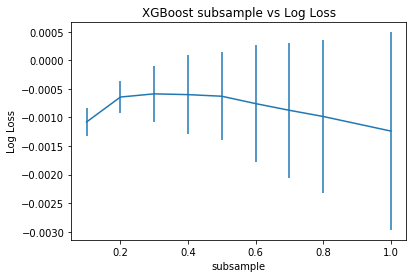

In [5]:
# plot
%matplotlib inline
pyplot.errorbar(subsample, means, yerr=stds)
pyplot.title("XGBoost subsample vs Log Loss")
pyplot.xlabel('subsample')
pyplot.ylabel('Log Loss')
pyplot.plot

We can plot these mean and standard deviation log loss values to get a better understanding of how performance varies with the subsample value.

We can see that indeed 30% has the best mean performance, but we can also see that as the ratio increased, the variance in performance grows quite markedly.

It is interesting to note that the mean performance of all subsample values outperforms the mean performance without subsampling (subsample=1.0).

# Tuning Column Subsampling in XGBoost By Tree
We can also create a random sample of the features (or columns) to use prior to creating each decision tree in the boosted model.

In the XGBoost wrapper for scikit-learn, this is controlled by the colsample_bytree parameter.

The default value is 1.0 meaning that all columns are used in each decision tree. We can evaluate values for colsample_bytree between 0.1 and 1.0 incrementing by 0.1.

In [6]:
from pandas import read_csv
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot
# load data
data = read_csv('train.csv')
dataset = data.values
# split data into X and y
X = dataset[:,0:94]
y = dataset[:,94]
# encode string class values as integers
label_encoded_y = LabelEncoder().fit_transform(y)
# grid search
model = XGBClassifier()
colsample_bytree = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
param_grid = dict(colsample_bytree=colsample_bytree)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, label_encoded_y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

/Users/Chanti/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/Chanti/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/Chanti/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/Chanti/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/Chanti/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/Chanti/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in s

Best: -0.001239 using {'colsample_bytree': 1.0}
-0.207180 (0.002001) with: {'colsample_bytree': 0.1}
-0.058896 (0.000609) with: {'colsample_bytree': 0.2}
-0.020926 (0.000494) with: {'colsample_bytree': 0.3}
-0.008090 (0.000715) with: {'colsample_bytree': 0.4}
-0.003916 (0.000913) with: {'colsample_bytree': 0.5}
-0.002066 (0.001157) with: {'colsample_bytree': 0.6}
-0.001479 (0.001346) with: {'colsample_bytree': 0.7}
-0.001310 (0.001489) with: {'colsample_bytree': 0.8}
-0.001239 (0.001729) with: {'colsample_bytree': 1.0}


<function matplotlib.pyplot.plot>

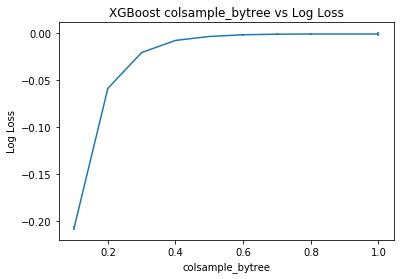

In [7]:
# plot
%matplotlib inline
pyplot.errorbar(colsample_bytree, means, yerr=stds)
pyplot.title("XGBoost colsample_bytree vs Log Loss")
pyplot.xlabel('colsample_bytree')
pyplot.ylabel('Log Loss')
pyplot.plot

Running this example prints the best configuration as well as the log loss for each tested configuration.

We can see that the best performance for the model was colsample_bytree=1.0. This suggests that subsampling columns on this problem does not add value.
Plotting the results, we can see the performance of the model plateau (at least at this scale) with values between 0.5 to 1.0.

# Tuning Column Subsampling in XGBoost By Split
Rather than subsample the columns once for each tree, we can subsample them at each split in the decision tree. In principle, this is the approach used in random forest.

We can set the size of the sample of columns used at each split in the colsample_bylevel parameter in the XGBoost wrapper classes for scikit-learn.

As before, we will vary the ratio from 10% to the default of 100%.

The full code listing is provided below.

In [1]:
# XGBoost on Otto dataset, tune colsample_bylevel
from pandas import read_csv
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot
# load data
data = read_csv('train.csv')
dataset = data.values
# split data into X and y
X = dataset[:,0:94]
y = dataset[:,94]
# encode string class values as integers
label_encoded_y = LabelEncoder().fit_transform(y)
# grid search
model = XGBClassifier()
colsample_bylevel = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
param_grid = dict(colsample_bylevel=colsample_bylevel)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, label_encoded_y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.001117 using {'colsample_bylevel': 0.7}
-0.134913 (0.001517) with: {'colsample_bylevel': 0.1}
-0.034222 (0.000813) with: {'colsample_bylevel': 0.2}
-0.008920 (0.000886) with: {'colsample_bylevel': 0.3}
-0.002783 (0.000647) with: {'colsample_bylevel': 0.4}
-0.001450 (0.000953) with: {'colsample_bylevel': 0.5}
-0.001124 (0.001122) with: {'colsample_bylevel': 0.6}
-0.001117 (0.001315) with: {'colsample_bylevel': 0.7}
-0.001124 (0.001428) with: {'colsample_bylevel': 0.8}
-0.001239 (0.001729) with: {'colsample_bylevel': 1.0}


<function matplotlib.pyplot.plot>

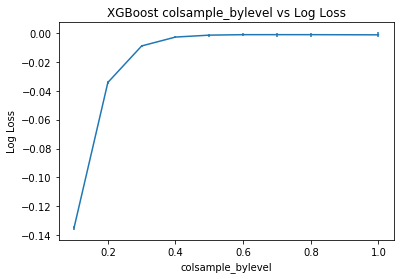

In [3]:
# plot
%matplotlib inline
pyplot.errorbar(colsample_bylevel, means, yerr=stds)
pyplot.title("XGBoost colsample_bylevel vs Log Loss")
pyplot.xlabel('colsample_bylevel')
pyplot.ylabel('Log Loss')
pyplot.plot